In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical

In [25]:
%matplotlib inline 

In [13]:
# Class for each data point in dataset (stores id, diagnosis, and path to audio file)
class Diagnosis():
    def __init__(self, id, diagnosis, path):
        self.id = id
        self.diagnosis = diagnosis
        self.path = path

In [14]:
# Returns list of paths to all audio files and path to audio files directory
def get_audio_files():
    audio_path = './data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
    files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))] # Gets all files in the audio_and_txt_files folder
    audio_files = [f for f in files if f.endswith('.wav')] # Gets all audio files (.wav)
    audio_files = sorted(audio_files)
    return audio_files, audio_path

In [15]:
# Processes all diagnoses and creates Diagnosis objects for each data point in dataset
def diagnosis_data():
    diagnosis = pd.read_csv('./data/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv')
    audio_files, audio_path = get_audio_files()
    diag_dict = { 101: "URTI" } # dictionary w/ id and diagnosis
    diag_list = []
    
    for index, row in diagnosis.iterrows():
        diag_dict[row[0]] = row[1]
    
    i = 0
    for f in audio_files:
        diag_list.append(Diagnosis(i, diag_dict[int(f[:3])], audio_path+f))
        i += 1
    return diag_list

In [16]:
def audio_features(filename):
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound)) # short-time Fourier transform (STFT) spectrogram
    
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40), axis=1) # Mel-frequency cepstral coefficients
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1) # Chromagram from STFT spectrogram
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate), axis=1) # Mel-scaled spectrogram
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1) # Spectral contrast
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate), axis=1) # Tonal centroid features
    
    features = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
    return features

In [17]:
def data_points():
    labels = []
    images = []
    
    encoding = { "COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7 }
    
    i = 0
    for f in diagnosis_data():
        print(i)
        labels.append(encoding[f.diagnosis])
        images.append(audio_features(f.path))
        i += 1
    return np.array(labels), np.array(images)

In [32]:
def preprocessing(labels, images):
    # Remove Asthma and LRTI because lack of data for those, will only hurt the model
    images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
    labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

    # Hot one encode the labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    # Format new data
    y_train = np.reshape(y_train, (y_train.shape[0], 6))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 6))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

    return X_train, X_test, y_train, y_test

In [33]:
print("Retrieving and processing data...")
labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)
print("Finished data retrieval and preprocessing!")

Retrieving and processing data...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


In [44]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=200, verbose=1)

Epoch 1/70
4/4 [==============================] - 2s 341ms/step - loss: 6.5203 - accuracy: 0.6739 - val_loss: 2.2199 - val_accuracy: 0.8967
Epoch 2/70
4/4 [==============================] - 2s 435ms/step - loss: 2.7237 - accuracy: 0.7544 - val_loss: 2.5587 - val_accuracy: 0.3370
Epoch 3/70
4/4 [==============================] - 2s 380ms/step - loss: 1.3333 - accuracy: 0.6603 - val_loss: 0.5883 - val_accuracy: 0.8967
Epoch 4/70
4/4 [==============================] - 1s 339ms/step - loss: 1.1377 - accuracy: 0.8568 - val_loss: 0.5813 - val_accuracy: 0.8967
Epoch 5/70
4/4 [==============================] - 1s 359ms/step - loss: 0.9549 - accuracy: 0.8568 - val_loss: 0.4575 - val_accuracy: 0.8967
Epoch 6/70
4/4 [==============================] - 2s 390ms/step - loss: 0.6533 - accuracy: 0.8568 - val_loss: 0.4222 - val_accuracy: 0.8967
Epoch 7/70
4/4 [==============================] - 1s 341ms/step - loss: 0.5398 - accuracy: 0.8554 - val_loss: 0.3796 - val_accuracy: 0.8967
Epoch 8/70
4/4 [====

4/4 [==============================] - 2s 428ms/step - loss: 0.1196 - accuracy: 0.9563 - val_loss: 0.1863 - val_accuracy: 0.9402
Epoch 60/70
4/4 [==============================] - 2s 470ms/step - loss: 0.1096 - accuracy: 0.9563 - val_loss: 0.1996 - val_accuracy: 0.9185
Epoch 61/70
4/4 [==============================] - 1s 353ms/step - loss: 0.1104 - accuracy: 0.9523 - val_loss: 0.1840 - val_accuracy: 0.9402
Epoch 62/70
4/4 [==============================] - 1s 345ms/step - loss: 0.1025 - accuracy: 0.9645 - val_loss: 0.1891 - val_accuracy: 0.9239
Epoch 63/70
4/4 [==============================] - 1s 340ms/step - loss: 0.1048 - accuracy: 0.9577 - val_loss: 0.1906 - val_accuracy: 0.9348
Epoch 64/70
4/4 [==============================] - 1s 350ms/step - loss: 0.0857 - accuracy: 0.9714 - val_loss: 0.2188 - val_accuracy: 0.9239
Epoch 65/70
4/4 [==============================] - 1s 344ms/step - loss: 0.0922 - accuracy: 0.9645 - val_loss: 0.1969 - val_accuracy: 0.9402
Epoch 66/70
4/4 [========

Accuracy: 95%
Loss: 0.1784



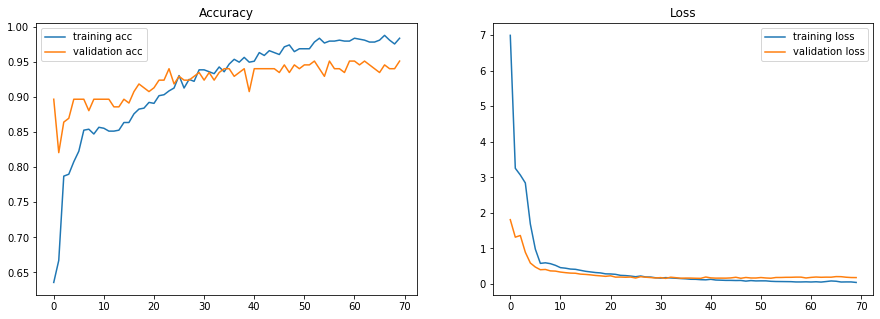

In [38]:
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

                precision    recall  f1-score   support

          COPD       0.99      0.99      0.99       165
       Healthy       0.67      0.57      0.62         7
          URTI       0.67      0.50      0.57         4
Bronchiectasis       1.00      0.75      0.86         4
     Pneumonia       0.60      1.00      0.75         3
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.95       184
     macro avg       0.65      0.63      0.63       184
  weighted avg       0.96      0.95      0.95       184



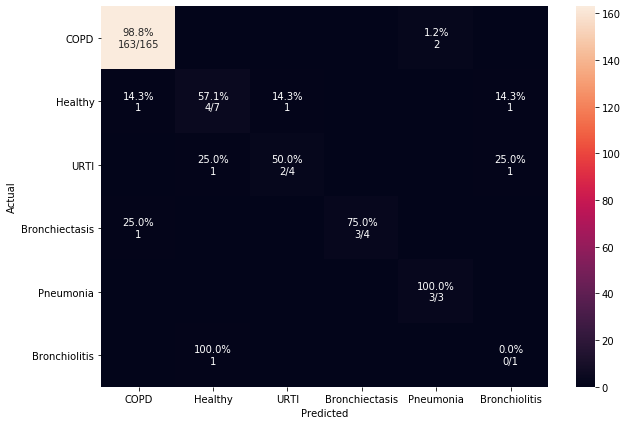

In [41]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumonia", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [43]:
np.sum(cm)

184